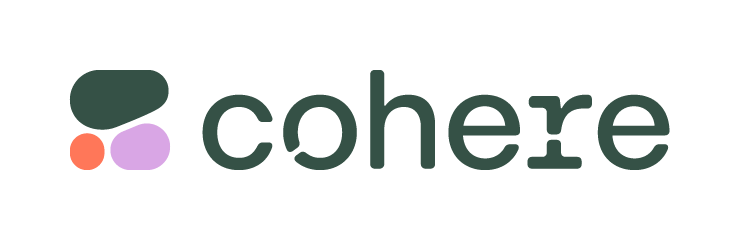

# Notebook Overview

## Motivation
Tabular data reasoning continues to be an exciting application of Agents, particularly in the financial domain, where multiple reasoning steps may be needed to identify the right answer. For example, a financial analyst working with financial statements may be interested in computing various financial ratios with natural language queries.

Some examples may include:
- ROE (Return on Equity) = Net Income / Shareholder's Equity
- Net Profit Margin = Net Income / Revenue
- Asset Turnover = Revenue / Average Total Assets
- Financial Leverage = Average Total Assets / Shareholder's Equity

Having an Agent which is able to correctly compute these and other ratios would be a great help for any analyst in the field of Finance.

## Objective
In this notebook we explore how to setup a [Cohere ReAct Agent](https://github.com/langchain-ai/langchain-cohere/blob/main/libs/cohere/langchain_cohere/cohere_agent.py) to answer questions over tables in Apple's SEC10K 2020 form. We show how this can be done with two variants of a langchain python tool, one that requires you to pass the full path of the dataframe and another that requires the dataframe objects to be loaded in memory. While there is no major difference between the two approaches, we present both to show how to manage files that are loaded in memory vs files in storage. 

## Table of Contents

- [Setup](#sec_step0)
- [Introduction](#sec_step1)
- [QnA over Single Table](#sec_step2)
    - [Agent with Python Tool](#sec_step2_sub1)
    - [Agent with Python Tool that takes tables as input](#sec_step2_sub2)
- [QnA over Multiple Tables](#sec_step3)

<a id="sec_step0"></a>
# Setup

In [3]:
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain.agents import AgentExecutor
from langchain_cohere.react_multi_hop.agent import create_cohere_react_agent
from langchain_core.prompts import ChatPromptTemplate
from langchain_cohere.chat_models import ChatCohere
import pandas as pd
from langchain.agents import Tool
from langchain_experimental.utilities import PythonREPL
from langchain_experimental.tools.python.tool import PythonAstREPLTool

In [5]:
####################################################################################################
#
# Uncomment if you need to install the following packages
#
####################################################################################################

#!pip install --quiet langchain langchain_cohere langchain_experimental --upgrade
#!pip install sec-api

<a id="sec_step1"></a>
# Introduction

The aim of this notebook is to showcase how Cohere Langchain Agents can be used to answer questions over tabular data.
This notebook assumes the input is a set of csv files extracted from Apples SEC 10K filings.

### Data Loading

We use the sec-api to download the income statement and balance sheet from the SEC 10K .htm file. Please note that the tables need to be parsed such that the index is numerical as the python code generation struggles to filter based on index. We have processed the tables and provided them for you.

In [6]:
income_statement = pd.read_csv('income_statement.csv')
balance_sheet = pd.read_csv('balance_sheet.csv')

<a id="sec_step2"></a>
# QnA over Single Table 

<a id="sec_step2_sub1"></a>
## Agent with Python Tool

In the example below, we show how the python tool can be used to load a dataframe and extract information from it. To do this successfully we need to:

1) pass the file name to the preamble so the model knows how to load the dataframe
2) pass a preview of the dataframe in the preamble so the model knows which columns/rows to query

First, let's implement the ReAct agent

In [9]:
# instantiate the Cohere llm
llm = ChatCohere(model="command-r", temperature=0.1,cohere_api_key="",verbose=True)

# create the python tool
python_repl = PythonREPL()
python_tool = Tool(
    name="python_repl",
    description="Executes python code and returns the result. The code runs in a static sandbox without interactive mode, so print output or save output to a file.",
    func=python_repl.run,
)
python_tool.name = "python_interpreter"

class ToolInput(BaseModel):
    code: str = Field(description="Python code to execute.")
python_tool.args_schema = ToolInput
tools=[python_tool]   

# define the prompt template
prompt = ChatPromptTemplate.from_template("{input}")

# instantiate the ReAct agent
agent = create_cohere_react_agent(
   llm=llm,
   tools=tools,
   prompt=prompt,
)
agent_executor = AgentExecutor(agent=agent,
                               tools=tools,
                               verbose=True,
                               return_intermediate_steps=True
                    )
# finally, define the preamble
preamble = """
You are an expert who answers the user's question. You are working with a pandas dataframe in Python. The name of the dataframe is `income_statement.csv`.
Here is a preview of the dataframe:
{head_df}
""".format(head_df=income_statement.head(3).to_markdown())


Then, we define the dictionary including the questions we want the Agent to answer, and their answer.

In [10]:
question_dict ={
    'q1': ['what is the highest value of cost of goods and service?',169559000000],
    'q2': ['what is the largest gross profit margin?',0.3836194330595236],
    'q3': ['what is the minimum ratio of operating income loss divided by non operating income expense',35.360599]
}

Let's now see how the Agent answers to each of the questions

In [19]:
for qsn,val in question_dict.items():
    print(f'question:{qsn}')
    agent_executor.invoke({
       "input": val[0],
       "preamble": preamble,
    })
    print(f'GT Answer:{val[1]}')
    print('-'*50)

question:q1


> Entering new AgentExecutor chain...

I will write and execute Python code to find the highest value of Cost of Goods and Services Sold from the provided dataframe.
{'tool_name': 'python_interpreter', 'parameters': {'code': 'import pandas as pd\n\n# Read the CSV file into a DataFrame\ndf = pd.read_csv(\'income_statement.csv\')\n\n# Find the highest value in the \'CostOfGoodsAndServicesSold\' column\nmax_value = df[\'CostOfGoodsAndServicesSold\'].max()\n\nprint(f"The highest value of Cost of Goods and Services Sold is {max_value}")'}}
The highest value of Cost of Goods and Services Sold is 169559000000.0
Relevant Documents: 0
Cited Documents: 0
Answer: The highest value of Cost of Goods and Services Sold is 169559000000.0.
Grounded answer: The highest value of Cost of Goods and Services Sold is <co: 0>169559000000.0</co: 0>.

> Finished chain.
GT Answer:169559000000
--------------------------------------------------
question:q2


> Entering new AgentExecutor chain...

I w

Nice! The agent uses the Python tool to write the code to access the data in the tables, and perform the required calculations.

<a id="sec_step2_sub2"></a>
## Agent with Python Tool that takes tables as input

In the example above, the model needs to load the dataframe in the python call before carrying out operations. In this example, we show how to pass the dataframes to the python tool so it has the file already loaded.

In [163]:
# call the PythonAstREPLTool in order to pass tables to the tool
df_locals = {'df':pd.read_csv('income_statement.csv')}
tools = [PythonAstREPLTool(locals=df_locals)]

agent = create_cohere_react_agent(
   llm=llm,
   tools=tools,
   prompt=prompt,
)
agent_executor = AgentExecutor(agent=agent,
                               tools=tools,
                               verbose=True,
                               return_intermediate_steps=True
                    )

preamble = """
You are an expert who answers the user's question. You are working with a pandas dataframe in Python. The name of the dataframe is `df`.
Here is a preview of the dataframe:
{head_df}
""".format(head_df=income_statement.head(3).to_markdown())


Let's loop again over the same dictionary of questions

In [20]:
for qsn,val in question_dict.items():
    print(f'question:{qsn}')
    agent_executor.invoke({
       "input": val[0],
       "preamble": preamble,
    })
    print(f'GT Answer:{val[1]}')
    print('-'*50)

question:q1


> Entering new AgentExecutor chain...

I will write and execute Python code to find the highest value of Cost of Goods and Services Sold from the provided dataframe.
{'tool_name': 'python_interpreter', 'parameters': {'code': "import pandas as pd\n\n# Read the CSV file into a DataFrame\ndf = pd.read_csv('income_statement.csv')\n\n# Find the highest value in the 'CostOfGoodsAndServicesSold' column\nmax_value = df['CostOfGoodsAndServicesSold'].max()\n\nprint(f'The highest value of Cost of Goods and Services Sold is {max_value:.2f}')\n"}}
The highest value of Cost of Goods and Services Sold is 169559000000.00
Relevant Documents: 0
Cited Documents: 0
Answer: The highest value of Cost of Goods and Services Sold is 169559000000.00.
Grounded answer: The highest value of Cost of Goods and Services Sold is <co: 0>169559000000.00</co: 0>.

> Finished chain.
GT Answer:169559000000
--------------------------------------------------
question:q2


> Entering new AgentExecutor chain...



Also in this case, the Agent correctly answers all the questions.

<a id="sec_step3"></a>
# QnA over Multiple Tables

We now make the task for the Agent more complicated, by asking it questions whose answer can be computed only by retrieving relevant information from multiple tables.

In [21]:
# define the Agent
python_repl = PythonREPL()
python_tool = Tool(
    name="python_repl",
    description="Executes python code and returns the result. The code runs in a static sandbox without interactive mode, so print output or save output to a file.",
    func=python_repl.run,
)
python_tool.name = "python_interpreter"

class ToolInput(BaseModel):
    code: str = Field(description="Python code to execute.")
python_tool.args_schema = ToolInput
tools=[python_tool]   

prompt = ChatPromptTemplate.from_template("{input}")
agent = create_cohere_react_agent(
   llm=llm,
   tools=tools,
   prompt=prompt,
)
agent_executor = AgentExecutor(agent=agent,
                               tools=tools,
                               verbose=True,
                               return_intermediate_steps=True
                    )

preamble = """
You are an expert who answers the user's question in complete sentences. You are working with two pandas dataframe in Python. Ensure your output is a string.

Here is a preview of the `income_statement.csv` dataframe:
{table_1}

Here is a preview of the `balance_sheet.csv` dataframe:
{table_2}
""".format(table_1=income_statement.head(3).to_markdown(),table_2=balance_sheet.head(3).to_markdown())


We now define a new question

In [27]:
question_dict ={
    'q1': ['what is the ratio of the largest stockholders equity to the smallest revenue'],
}

The answer to this question can be obtained only by accessing both the balance sheet and the income statement, as show below:

In [29]:
# get the largest stockholders equity
x = balance_sheet['StockholdersEquity'].astype(float).max()
print(f"The largest stockholders equity value is: {x}")

# get the smallest revenue
y = income_statement['RevenueFromContractWithCustomerExcludingAssessedTax'].astype(float).min()
print(f"The smallest revenue value is: {y}")

# compute the ratio
ratio = x/y
print(f"Their ratio is: {ratio}")

The largest stockholders equity value is: 134047000000.0
The smallest revenue value is: 53809000000.0
Their ratio is: 2.4911631883142227


Let's now get the answer from the Agent

In [34]:
for qsn,val in question_dict.items():
    print(f'question:{qsn}')
    agent_executor.invoke({
       "input": val[0],
       "preamble": preamble,
    })

question:q1


> Entering new AgentExecutor chain...

I will write and execute Python code to find the largest and smallest values in the relevant columns of the dataframes, then calculate the ratio.
{'tool_name': 'python_interpreter', 'parameters': {'code': "import pandas as pd\n\nincome_statement = pd.read_csv('income_statement.csv')\nbalance_sheet = pd.read_csv('balance_sheet.csv')\n\n# Find largest and smallest values in relevant columns\nmax_stockholders_equity = max([balance_sheet['StockholdersEquity'].iloc[i] for i in range(len(balance_sheet))])\nmin_revenue = min([income_statement['RevenueFromContractWithCustomerExcludingAssessedTax'].iloc[i] for i in range(len(income_statement))])\n\n# Calculate ratio\nratio = max_stockholders_equity / min_revenue\n\nprint(f'The ratio of the largest stockholders equity to the smallest revenue is {ratio:.2f}'\n    )"}}
NameError("name 'balance_sheet' is not defined")
My code has thrown an error because the variable `balance_sheet` has not been d

The Agent defined a plan ("write and execute Python code to find the largest and smallest values in the relevant columns of the dataframes, then calculate the ratio") and executed it. It made some mistakes when coding, that resulted in NameError errors, but it fixed them and finally got to the correct answer